In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import myfm

# read movielens 100k data.
from myfm.utils.benchmark_data import MovieLens100kDataManager
data_manager = MovieLens100kDataManager()
df_train, df_test = data_manager.load_rating_predefined_split(fold=3) # Note the dependence on the fold

In [2]:
df_train.head()

,user_id,movie_id,rating,timestamp
0,1,1,5,1997-09-22 22:02:38
1,1,2,3,1997-10-15 05:26:11
2,1,3,4,1997-11-03 07:42:40
3,1,4,3,1997-10-15 05:25:19
4,1,6,5,1998-02-14 04:52:53


In [3]:
def test_myfm(df_train, df_test, rank=8, grouping=None, task="regression", n_iter=200, samples=195, variational=False):
    explanation_columns = ['user_id', 'movie_id']
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train = ohe.fit_transform(df_train[explanation_columns])
    X_test = ohe.transform(df_test[explanation_columns])
    y_train = df_train.rating.values
    y_test = df_test.rating.values
    if task == "classification":
        y_train = y_train >= 4
        y_test = y_test >=4
        if variational:
            fm = myfm.VariationalFMClassifier(rank=rank, random_seed=334)
        else:
            fm = myfm.MyFMClassifier(rank=rank, random_seed=334)
    elif task == "ordered":
        y_train = y_train - 1
        y_test = y_test - 1
        if variational:
            raise ValueError('Variational infrence for ordinal regression is not available.')
        fm = myfm.MyFMOrderedProbit(rank=rank, random_seed=334)
    elif task == "regression":
        if variational:
            fm = myfm.VariationalFMRegressor(rank=rank, random_seed=334)
        else:
            fm = myfm.MyFMRegressor(rank=rank, random_seed=334)
    else:
        raise ValueError("Unknown task type")
    
    if grouping:
        grouping = [ i for i, category in enumerate(ohe.categories_) for _ in category]
    X_train *= 1
    X_test *= 1
    fm.fit(X_train, y_train, grouping=grouping, n_iter=n_iter, n_kept_samples=samples)
    
    if task == "classification":
        prediction = fm.predict_proba(X_test)
        roc = metrics.roc_auc_score(y_test, prediction)
        ll = metrics.log_loss(y_test, prediction)
        print('roc={roc}, ll={ll}'.format(roc=roc, ll=ll))
    elif task == "ordered":
        prediction_prob = fm.predict_proba(X_test)
        ll = metrics.log_loss(y_test, prediction_prob)
        prediction = prediction_prob.dot(np.arange(5))
        rmse = ((y_test - prediction) ** 2).mean() ** .5
        mae = np.abs(y_test - prediction).mean()
        print('rmse={rmse}, mae={mae}, ll={ll}'.format(rmse=rmse, mae=mae, ll=ll))
    else:
        prediction = fm.predict(X_test)
        rmse = ((y_test - prediction) ** 2).mean() ** .5
        mae = np.abs(y_test - prediction).mean()
        print('rmse={rmse}, mae={mae}'.format(rmse=rmse, mae=mae))
        
    if variational:
        plt.plot(
            fm.history_.elbos
        )
        plt.title('ELBO')
    return fm

### Regression

In [4]:
# basic regression
test_myfm(df_train, df_test, rank=8, task="regression");

alpha = 1.57 w0 = 3.29 : 100%|██████████| 200/200 [00:03<00:00, 60.68it/s]
rmse=0.895337688159742, mae=0.703725767261822


In [5]:
# with grouping
fm = test_myfm(df_train, df_test, rank=8, grouping=True, task="regression")

alpha = 1.55 w0 = 3.55 : 100%|██████████| 200/200 [00:02<00:00, 67.41it/s]
rmse=0.8925703685663464, mae=0.6994701163216454


alpha = 1.39 w0 = 3.42 : 100%|██████████| 200/200 [00:03<00:00, 50.13it/s]
rmse=0.8999012948774495, mae=0.7065068266726349


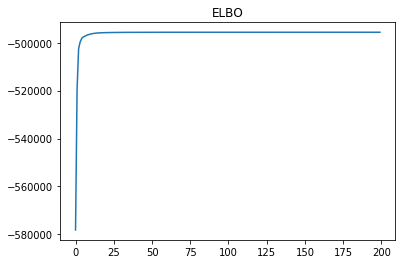

In [6]:
# variational inference
vfm = test_myfm(df_train, df_test, rank=8, grouping=True, task="regression", variational=True)

### Classification

In [7]:
test_myfm(df_train, df_test, rank=8, task="classification");

w0 = -0.21 : 100%|██████████| 200/200 [00:05<00:00, 39.46it/s]
roc=0.7810838988854009, ll=0.5573255850553199


In [8]:
test_myfm(df_train, df_test, rank=8, grouping=True, task="classification");

w0 = 0.10 : 100%|██████████| 200/200 [00:05<00:00, 39.63it/s]
roc=0.7894469687637761, ll=0.548414137210259


w0 = 0.12 : 100%|██████████| 200/200 [00:04<00:00, 41.99it/s]
roc=0.7811452320250709, ll=0.5571006078298371


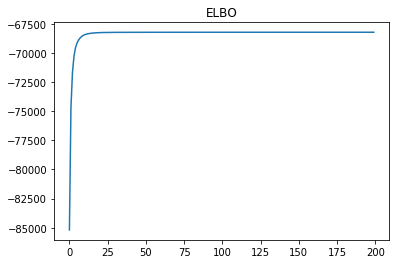

In [9]:
test_myfm(df_train, df_test, rank=8, grouping=True, task="classification", variational=True);

### Ordered Probit Regression

If you further increase `n_iter` and `samples`, the ordered probit regression will outperform the basic regression.

In [10]:
test_myfm(df_train, df_test, rank=8, task="ordered");

, cutpoint = ['-1.977', '-1.048', '0.132', '1.473'] : 100%|██████████| 200/200 [00:13<00:00, 14.93it/s]
rmse=0.8960106802674372, mae=0.7059004389265603, ll=1.2354723637906164


In [11]:
probit_fm = test_myfm(df_train, df_test, rank=8, grouping=True, task="ordered")

, cutpoint = ['-2.210', '-1.258', '-0.090', '1.246'] : 100%|██████████| 200/200 [00:13<00:00, 14.85it/s]
rmse=0.890452537829197, mae=0.6996779335086092, ll=1.227986437704297


### Trace plot of hyper parameters

In [12]:
trace = fm.get_hyper_trace()
trace.head()

,alpha,mu_w[0],mu_w[1],lambda_w[0],lambda_w[1],"mu_V[0,0]","mu_V[0,1]","mu_V[0,2]","mu_V[0,3]","mu_V[0,4]",...,"lambda_V[0,6]","lambda_V[0,7]","lambda_V[1,0]","lambda_V[1,1]","lambda_V[1,2]","lambda_V[1,3]","lambda_V[1,4]","lambda_V[1,5]","lambda_V[1,6]","lambda_V[1,7]"
0,0.076807,0.005563,0.001483,92.077199,93.284354,0.001326,-0.004398,0.002185,-0.005862,-0.000151,...,82.685256,106.945666,90.626599,91.514950,100.024087,89.684403,99.975719,91.584779,95.433350,98.680053
1,0.824358,0.007567,0.005176,84.033669,92.208692,0.003677,-0.002461,0.002267,-0.009944,0.005286,...,84.785689,101.947123,94.176841,81.329649,94.461156,84.167331,85.804663,80.865688,91.291856,90.479410
2,1.012980,0.016978,-0.003217,22.649358,35.966045,0.009943,-0.002421,0.001312,-0.003885,-0.001156,...,82.667311,96.150252,88.475626,72.705480,79.325036,81.643681,82.994274,64.937051,85.783673,81.772258
3,1.103191,0.017370,-0.027115,10.671300,13.604462,-0.000468,-0.003225,-0.003626,-0.004687,0.000434,...,79.223295,90.697729,79.597543,67.538844,76.340068,78.341913,76.229624,61.300734,79.461582,75.996429
4,1.135381,0.045122,-0.069559,7.091831,6.537278,0.004311,-0.002707,-0.006611,0.003754,-0.005209,...,77.855208,83.278313,74.785584,61.246989,75.701861,75.841273,69.801051,63.293471,74.138065,74.183499


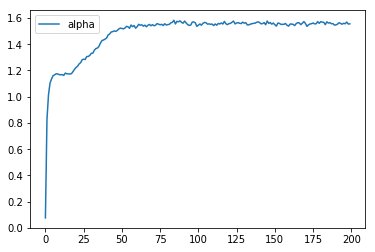

In [13]:
trace[['alpha']].plot();

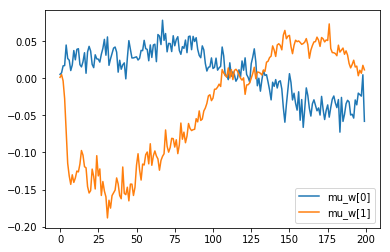

In [14]:
trace[[c for c in trace.columns if c.startswith('mu_w')]].plot();

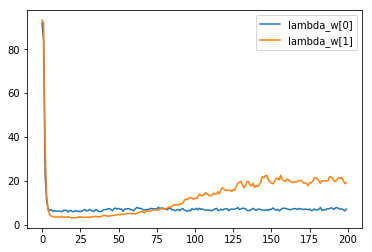

In [15]:
trace[[c for c in trace.columns if c.startswith('lambda_w')]].plot();

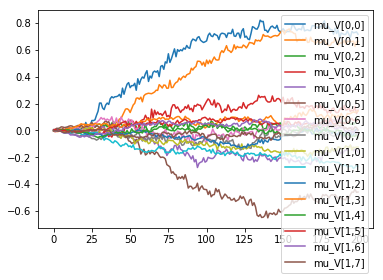

In [16]:
trace[[c for c in trace.columns if c.startswith('mu_V')]].plot();

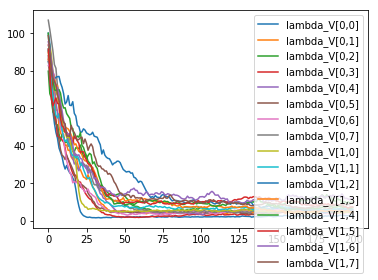

In [17]:
trace[[c for c in trace.columns if c.startswith('lambda_V')]].plot();

### Cutpoints vs ratings

A slight non-linearity seems to exist.  
That might explain why the performance improves if we use ordered probit regression.

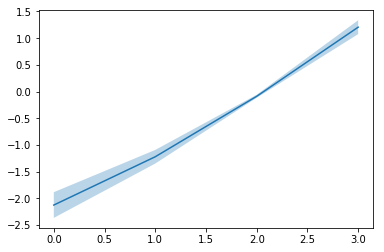

In [18]:
cutpoints = np.vstack([x.cutpoints[0] for x in probit_fm.predictor_.samples])

cp_std = cutpoints.std(axis=0)
cp_mean = cutpoints.mean(axis=0)
plt.plot(cp_mean);
plt.fill_between(np.arange(4), cp_mean - 2 * cp_std, cp_mean + cp_std * 2, alpha=0.3);